In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F

from datetime import datetime
import math

from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
dscovr_data = {}
for file in os.listdir("/kaggle/input/dscovr-data"):
    if file.count("dsc"):
        dscovr_data["yr_"+file.split("_")[4]] = pd.read_csv(os.path.join("/kaggle/input/dscovr-data", file), index_col=False).iloc[1:]

/tmp/ipykernel_28/3663265967.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dscovr_data["yr_"+file.split("_")[4]] = pd.read_csv(os.path.join("/kaggle/input/dscovr-data", file), index_col=False).iloc[1:]
/tmp/ipykernel_28/3663265967.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dscovr_data["yr_"+file.split("_")[4]] = pd.read_csv(os.path.join("/kaggle/input/dscovr-data", file), index_col=False).iloc[1:]
/tmp/ipykernel_28/3663265967.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dscovr_data["yr_"+file.split("_")[4]] = pd.read_csv(os.path.join("/kaggle/input/dscovr-data", file), index_col=False).iloc[1:]
/tmp/ipykernel_28/3663265967.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data wit

In [5]:
for key in dscovr_data.keys():
    dscovr_data[key]["DOY"] = dscovr_data[key]["Date"].apply(lambda x: int(datetime.fromisoformat(x).timetuple().tm_yday))
    dscovr_data[key]["YEAR"] = dscovr_data[key]["Date"].apply(lambda x: int(datetime.fromisoformat(x).year))
    dscovr_data[key]["HR"] = dscovr_data[key]["Time"].apply(lambda x: int(x.split(":")[0])+int(x.split(":")[1])/60)
    dscovr_data[key]["Bt"] = np.sum(dscovr_data[key][["Bx", "By", "Bz"]]**2, axis=1)**0.5
    
    dscovr_data[key] = dscovr_data[key].drop(columns=["Date", "Time"])

In [6]:
flow_max = 0
for key in dscovr_data.keys():
    flow_max = max(np.max(dscovr_data[key][dscovr_data[key].columns[3:-4]].to_numpy()), flow_max)
    
print(flow_max)

6529.59


In [7]:
for key in dscovr_data.keys():
    dscovr_data[key][dscovr_data[key].columns[3:-4]]/=flow_max

In [8]:
bt_max = 0
for key in dscovr_data.keys():
    bt_max = max(np.max(dscovr_data[key]["Bt"].to_numpy()), bt_max)
    
print(bt_max)

35.4173932076854


In [9]:
for key in dscovr_data.keys():
    dscovr_data[key][["Bx", "By", "Bz", "Bt"]]/=bt_max

In [10]:
dscovr_data["yr_2016"]

,Bx,By,Bz,fp0,fp1,fp2,fp3,fp4,fp5,fp6,...,fp43,fp44,fp45,fp46,fp47,fp48,DOY,YEAR,HR,Bt
1,0.191073,-0.093229,-0.366958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,2016,0.016667,0.424098
2,0.180450,-0.073741,-0.376287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,2016,0.033333,0.423783
3,0.182085,-0.073841,-0.376366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,2016,0.050000,0.424569
4,0.185998,-0.077104,-0.373718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,2016,0.066667,0.424506
5,0.182079,-0.075914,-0.375736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,2016,0.083333,0.424374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283675,-0.167249,0.091856,-0.058523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,366,2016,23.916667,0.199586
283676,-0.172505,0.076991,-0.055279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,366,2016,23.933333,0.196828
283677,-0.163337,-0.057204,-0.074555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,366,2016,23.950000,0.188440
283678,-0.101801,-0.149961,-0.089348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,366,2016,23.966667,0.202076


In [11]:
dscovr_data_combined = pd.concat([dscovr_data[key] for key in sorted(list(dscovr_data.keys()))])
#dscovr_data_combined=dscovr_data_combined[(dscovr_data_combined["Bx"].isna()==False)]

In [78]:
na_vals = dscovr_data_combined[dscovr_data_combined["Bx"].isna() | dscovr_data_combined["By"].isna() | dscovr_data_combined["Bz"].isna()][["DOY", "YEAR", "HR"]]
for row_idx in tqdm(range(len(na_vals))):
    dscovr_data_combined = dscovr_data_combined[((dscovr_data_combined["YEAR"]==na_vals.iloc[1]["YEAR"]) & ((dscovr_data_combined["DOY"]==na_vals.iloc[1]["DOY"]) & (np.floor(dscovr_data_combined["HR"])==np.floor(na_vals.iloc[1]["HR"])))==False)]

  1%|          | 124/17435 [01:07<2:37:13,  1.84it/s]


KeyboardInterrupt: 

In [12]:
kp_data = pd.read_csv("/kaggle/input/dscovr-data/kP_index_data.csv")
kp_data["HR"] = kp_data["HR"].apply(lambda x: float(x))
kp_data["kP"] = kp_data["kP"].apply(lambda x: float(x)/10)

# Naive Time Series Classification

In [13]:
def df_to_tensor(df):
    return torch.tensor(df.to_numpy())

In [38]:
def sliding_window(window_size, x_split, jump, index):
    full_window = np.arange(jump*index, window_size+jump*index)
    x_idxs = full_window[:x_split]
    y_idxs = full_window[x_split:]
    
    return x_idxs, y_idxs
    
class ForecastingDataset(Dataset):
    def __init__(self, data, window_size = 360, x_split = 240, jump=60):
        self.idx_length = (len(data)-window_size)//jump + 1
        
        self.data = data
        self.window_size = window_size
        self.x_split = x_split
        self.jump = jump
        
    def __len__(self):
        return self.idx_length
    
    def __getitem__(self, idx):
        x_idxs, y_idxs = sliding_window(self.window_size, self.x_split, self.jump, idx)
        
        return self.data.iloc[x_idxs], self.data.iloc[y_idxs]
    
class kPPredictionDataset(Dataset):
    def __init__(self, dscovr_data, kp_data, window_size = 60*6, x_split = 5*60, jump=1*60):
        self.idx_length = (len(dscovr_data)-window_size)//jump + 1
        
        self.dscovr_data = dscovr_data
        self.kp_data = kp_data
        self.window_size = window_size
        self.x_split = x_split
        self.jump = jump
        
    def __len__(self):
        return self.idx_length
    
    def __getitem__(self, idx):
        x_idxs, y_idxs = sliding_window(self.window_size, self.x_split, self.jump, idx)
        y_kp = []
        
        for row_idx in range(len(y_idxs)//60):
            
            hour = np.ceil(self.dscovr_data.iloc[y_idxs[(row_idx+1)*60-1]]["HR"])%24
            year = self.dscovr_data.iloc[y_idxs[(row_idx+1)*60-1]]["YEAR"]
            doy = self.dscovr_data.iloc[y_idxs[(row_idx+1)*60-1]]["DOY"]
            
            y_kp.append(self.kp_data[(self.kp_data["HR"]==hour) & (self.kp_data["DOY"]==doy) & (self.kp_data["YEAR"]==year)]["kP"].to_numpy())
        
        return df_to_tensor(self.dscovr_data.iloc[x_idxs].drop(columns=["YEAR", "HR", "DOY"])), torch.tensor(np.stack(y_kp))

In [39]:
kp_ds = kPPredictionDataset(dscovr_data_combined, kp_data)
train_set, val_set = torch.utils.data.random_split(kp_ds, [int(len(kp_ds)*0.9), len(kp_ds)-int(len(kp_ds)*0.9)])
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=16)
test_dataloader = DataLoader(train_set, shuffle=True, batch_size=16)

del kp_ds

In [48]:
train_set[11]
#kp_data[(kp_data["HR"]==1.0) & (kp_data["DOY"]==1.0) & (kp_data["YEAR"]==2016)]

(tensor([[-0.0981,  0.0641,  0.0013,  ...,  0.0000,  0.0000,  0.1172],
         [-0.0718,  0.0589,  0.0150,  ...,  0.0000,  0.0000,  0.0941],
         [-0.0649,  0.0502,  0.0196,  ...,  0.0000,  0.0000,  0.0843],
         ...,
         [-0.0582,  0.1509, -0.0330,  ...,  0.0000,  0.0000,  0.1651],
         [-0.0586,  0.1495, -0.0212,  ...,  0.0000,  0.0000,  0.1619],
         [-0.0591,  0.1491, -0.0275,  ...,  0.0000,  0.0000,  0.1627]],
        dtype=torch.float64),
 tensor([[2.7000]], dtype=torch.float64))

In [46]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device)
        
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [49]:
kP_model = LSTM(1, 53, 256, 1).to(device)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(kP_model.parameters(), lr=0.01)

In [55]:
loss_vals = []

kP_model.train()

for epoch in range(4):
    total_loss = 0
    for i, (x, y) in tqdm(enumerate(train_dataloader)):
        x = torch.nan_to_num(x).to(device).float()
        y = torch.nan_to_num(y).to(device).float().squeeze(-1).squeeze(-1)
        
        outputs = kP_model(x)

        # obtain the loss function
        loss = criterion(outputs.squeeze(), y)
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        total_loss+=loss.item()
    
    loss_vals.append(total_loss/(len(train_set)))
    print(f"epoch: {epoch}, total loss: {total_loss}")
    
kP_model.eval()

3073it [03:45, 13.65it/s]


epoch: 0, total loss: 1861.532452210784


3073it [03:46, 13.59it/s]


epoch: 1, total loss: 1825.5473175793886


3073it [03:45, 13.63it/s]


epoch: 2, total loss: 1801.0202215760946


3073it [03:45, 13.61it/s]

epoch: 3, total loss: 1812.941697947681


LSTM(
  (lstm): LSTM(53, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

Text(0, 0.5, 'MSE Loss (lower is better)')

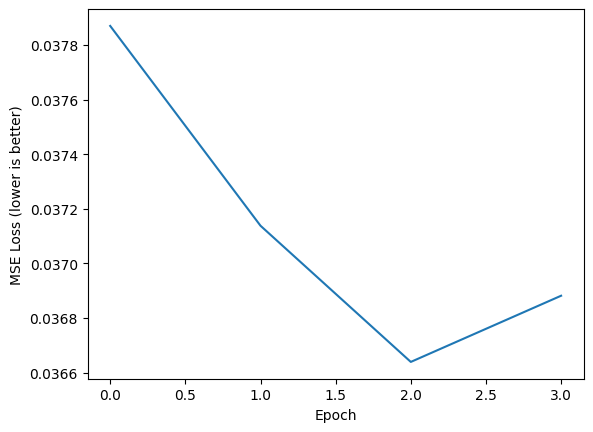

In [56]:
plt.plot(loss_vals)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (lower is better)")

In [57]:
kP_real = np.stack([train_set[idx][1][0, 0].numpy() for idx in tqdm(range(100))])
kP_real

100%|██████████| 100/100 [00:00<00:00, 278.70it/s]


array([1.7, 1.3, 0.7, 4. , 2. , 1.3, 2. , 4. , 1.3, 0.3, 2.7, 2.7, 3.3,
       1. , 0. , 0.7, 3. , 1.7, 3. , 1.7, 2.7, 2. , 2.3, 1. , 1. , 0.7,
       0.3, 1. , 1. , 3.3, 1.7, 0. , 1. , 0. , 0.7, 3. , 1.3, 2. , 3.7,
       3. , 0.3, 3.7, 2. , 0.3, 4.3, 0.3, 0.7, 6.3, 0.3, 2.3, 1.7, 3.3,
       2.3, 0.7, 5.3, 3. , 2.3, 0.3, 1. , 2.3, 0.7, 1.3, 1. , 3. , 1.3,
       1.3, 2.7, 3.3, 3.3, 1.3, 0.3, 3. , 0. , 0.3, 1.7, 2. , 3.7, 2.7,
       1.3, 0.7, 2. , 0.7, 1.3, 0.7, 4. , 0. , 2.7, 1.3, 4.3, 1.7, 3.3,
       0.3, 1.7, 0. , 3.3, 2.3, 1. , 1. , 1. , 0.7])

In [58]:
with torch.no_grad():
    kP_pred = np.array([kP_model(torch.nan_to_num(train_set[idx][0]).unsqueeze(0).to(device).float()).item() for idx in tqdm(range(100))])

100%|██████████| 100/100 [00:00<00:00, 119.31it/s]


In [70]:
fig, ax = plt.subplots(ncols=3)
ax[0].plot(kP_real[:100])
ax[1].plot(kP_real[:100])
ax[1].plot(kP_pred[:100]*1.3, color="red")
ax[2].plot(kP_pred[:100]*1.3)

<IPython.core.display.Javascript object>

# Predictions Based on Scalar B, Bx, By, Bz, Proton Density, Plasma Speed, and Flow Pressure

In [101]:
var_df = pd.read_csv("/kaggle/input/dscovr-data/correlated_vars.csv")
var_df["Bt"] = np.sum(var_df[["Bx", "By", "Bz"]]**2, axis=1)**0.5
var_df["DOY"]/=365

In [9]:
class ConversionDataset(Dataset):
    def __init__(self, data_df, input_columns = ["Bx", "By", "Bz"], output_columns = ["SWPD", "SWPS", "Fp"]):
        self.data = data_df
        self.input_columns = input_columns
        self.output_columns = output_columns
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return torch.tensor(self.data.iloc[idx][self.input_columns]), torch.tensor(self.data.iloc[idx][self.output_columns])

In [6]:
class ConversionPredictor(nn.Module):

    def __init__(self, num_inputs, num_outputs, hidden_sizes = [32, 64, 128, 64]):
        super(ConversionPredictor, self).__init__()
        
        self.bn = nn.BatchNorm1d(3)
        
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.hidden_sizes = hidden_sizes
        
        self.input_layer = nn.Linear(num_inputs, hidden_sizes[0])
        
        hidden_layers = []
        for idx in range(len(hidden_sizes)-1):
            hidden_layers.append(nn.Linear(hidden_sizes[idx], hidden_sizes[idx+1]))
            hidden_layers.append(nn.ReLU())
            
        self.hidden = nn.Sequential(*hidden_layers)
        
        self.output_layer = nn.Linear(hidden_sizes[-1], num_outputs)

    def forward(self, x):
        
        x = self.bn(x)
        
        x = F.relu(self.input_layer(x))
        x = self.hidden(x)
        
        out = self.output_layer(x)
        
        return out

In [10]:
train_set, val_set = torch.utils.data.random_split(ConversionDataset(var_df, output_columns=["SWPD"]), [int(len(var_df)*0.8), len(ConversionDataset(var_df))-int(len(var_df)*0.8)])
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=128)
test_dataloader = DataLoader(train_set, shuffle=True, batch_size=128)

In [11]:
conv_pred = torch.nn.Linear(3, 1).to(device)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(conv_pred.parameters(), lr=0.01)

In [23]:
loss_vals = []

conv_pred.train()

for epoch in range(10):
    total_loss = 0
    for i, (x, y) in tqdm(enumerate(train_dataloader)):
        x = x.to(device).float()
        y = y.to(device).float()
        
        outputs = conv_pred(x)

        # obtain the loss function
        loss = criterion(outputs, y)
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        total_loss+=loss.item()
    
    loss_vals.append(total_loss/len(train_set))
    print(f"epoch: {epoch}, total loss: {total_loss/len(train_set)}")
    
conv_pred.eval()

402it [01:04,  6.25it/s]


epoch: 0, total loss: 46.52482881259748


402it [01:04,  6.25it/s]


epoch: 1, total loss: 46.51835877209895


402it [01:04,  6.28it/s]


epoch: 2, total loss: 46.33481880194366


402it [01:04,  6.27it/s]


epoch: 3, total loss: 46.44832006388165


402it [01:04,  6.28it/s]


epoch: 4, total loss: 46.5532939386772


402it [01:04,  6.27it/s]


epoch: 5, total loss: 46.473924830075006


402it [01:04,  6.27it/s]


epoch: 6, total loss: 46.490827807353696


402it [01:04,  6.27it/s]


epoch: 7, total loss: 46.64859893780139


402it [01:04,  6.27it/s]


epoch: 8, total loss: 46.1683730730531


402it [01:04,  6.27it/s]

epoch: 9, total loss: 46.64888680260274


Linear(in_features=3, out_features=1, bias=True)

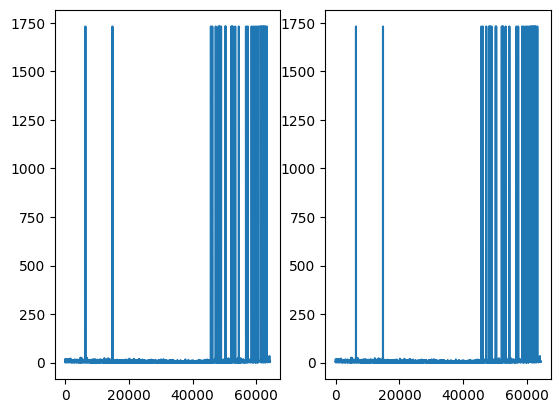

In [121]:
fig, ax = plt.subplots(ncols=2)
#ax[0].plot(var_df["SWPD"][:12*60])
#ax[1].plot(conv_pred(torch.tensor(var_df[["Bx", "By", "Bz"]].iloc[:12*60].to_numpy()).to(device).float()).squeeze().detach().cpu().numpy())
ax[0].plot(var_df["Bt"])
#ax[0].set_ylim(-2, 26)
ax[1].plot(np.sum(var_df[["Bx", "By", "Bz"]]**2, axis=1)**0.5)
#ax[1].set_ylim(-2, 26)
#ax[2].plot(var_df["By"][:12*60])
#ax[3].plot(var_df["Bx"][:12*60])

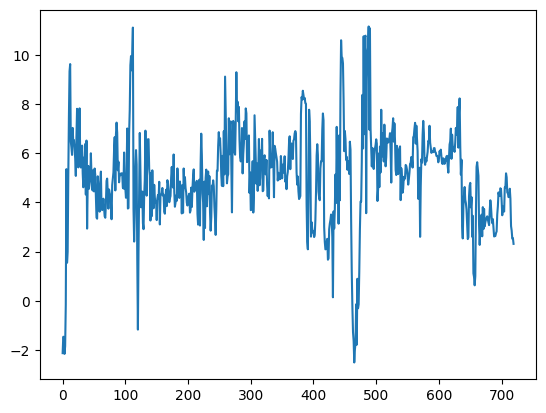

In [19]:
plt.plot(conv_pred(torch.tensor(var_df[["Bx", "By", "Bz"]].iloc[:12*60].to_numpy()).to(device).float()).squeeze().detach().cpu().numpy())

(-2.0, 20.0)

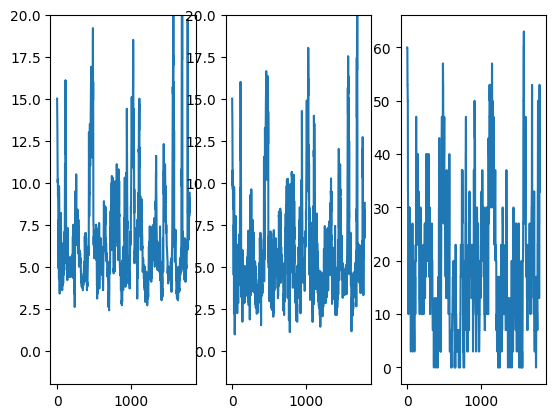

In [52]:
hrs = 30
fig, ax = plt.subplots(ncols=3)
ax[0].plot(var_df["Bt"][:hrs*60])
ax[1].plot(np.sum(var_df[["Bx", "By", "Bz"]].iloc[:hrs*60]**2, axis=1)**0.5)
ax[2].plot(var_df["Kp"].iloc[:hrs*60])
ax[0].set_ylim(-2, 20)
ax[1].set_ylim(-2, 20)

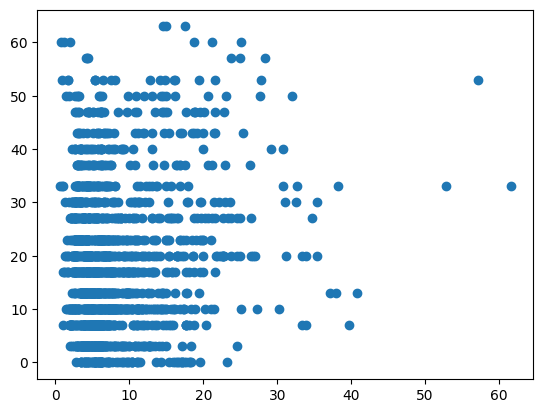

In [53]:
plt.scatter(var_df["SWPD"][:hrs*60], var_df["Kp"].iloc[:hrs*60])